#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [ ]:
!which python

/usr/local/bin/python


# Install dependencies:

In [4]:
install_packages = False
if install_packages:
    !conda install -c conda-forge tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

# Imports

In [7]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [17]:
data_path = './input/videoinfo_LNt-JsBMj4k_2020_11_26-11_36_19_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [18]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Creation of the directory /content/drive/My Drive/Colab Notebooks/CSMA/assignment5/output/ failed


# Load Data
Load you data as a pandas dataframe

In [19]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))

In [20]:
data.head()

,id,replyCount,likeCount,publishedAt,authorName,text,authorChannelId,authorChannelUrl,isReply,isReplyTo,isReplyToName
0,UgzCBg4fqfXe7AjHCDV4AaABAg,29.0,44,2020-11-05 21:23:23,Our Changing Climate,"💡 Please take a second to share this video on Reddit, Facebook, or Twitter!<br />🌍 What other climate change solutions are you interested in learning more about?",UCNXvxXpDJXp-mZu3pFMzYHQ,http://www.youtube.com/channel/UCNXvxXpDJXp-mZu3pFMzYHQ,0,NaN,NaN
1,UgzCBg4fqfXe7AjHCDV4AaABAg.9FgqTgJxWQT9GZuu2d5iVV,NaN,0,2020-11-27 15:59:32,jd94sho1,"Please look into Generation 4 nuclear energy, especially the Elysium Industries Molten Chloride Salt Fast reactor, which is capable of using current reactor fleet spent fuel without reprocessing. This means we already have enough fuel just sitting in casks to power the globe for decades. http://www.elysiumindustries.com/technology",UC21Ii2jEyy3VnSNLTCLmgQg,http://www.youtube.com/channel/UC21Ii2jEyy3VnSNLTCLmgQg,1,UgzCBg4fqfXe7AjHCDV4AaABAg,Our Changing Climate
2,UgzCBg4fqfXe7AjHCDV4AaABAg.9FgqTgJxWQT9GR30Ak1a9k,NaN,0,2020-11-24 05:25:59,Anna Reyes,"@Andrew Yang What makes you believe that without the violent force of government to coerce people to contribute to certain causes, there would be no greater solutions to the problems that we face?",UCSWMlZen4CyE6u12fPC1QYw,http://www.youtube.com/channel/UCSWMlZen4CyE6u12fPC1QYw,1,UgzCBg4fqfXe7AjHCDV4AaABAg,Our Changing Climate
3,UgzCBg4fqfXe7AjHCDV4AaABAg.9FgqTgJxWQT9GR29ZEaYji,NaN,0,2020-11-24 05:18:32,Andrew Yang,"@Anna Reyes what I'm saying is that market solutions on their own don't get you below 2 degrees C fast enough. They might get you to 3 degrees C -- if you are lucky and design a carbon tax that is sufficiently high. I look at this problem as an engineer, by the way, not an economist. And the way I see it, government itself is not the problem. The problem is the way that the political apparatus has been misused and poorly designed to handle a fast transition away from fossil fuel burning machines and towards electricity powered machines. Oh and by the way, I was using the prior example of fossil fuel subsidies as an example of Republican hypocrisy. The reality is that as even though the market currently favors renewable energy, someone had to make that happen. And guess what -- the states made this happen with renewable energy mandates and subsidies. My point in general is that Republicans cannot point to their ""free market"" bona fides when they decide that they would rather pick and choose which kinds of government mandates are ""good"" and which are ""bad and stifling."" To be very clear here, I am a capitalist (of the Mariana Mazzucato variety, so further to the left than most mainstream economists). But I believe government to be the referee that steps in and hands red cards to bad actors and gives rewards for good behavior (esp when the free market cannot be trusted to do its own thing correctly with an inelastic good like health insurance, or life-saving drugs, or clean electricity, or clean water). Central to this is the art of the ""public-private"" partnership -- of industry collaborating with policymakers for the good of society (because engineers are great at doing one thing -- making things progressively more efficient over time, when given a design challenge). Think initiatives like the Apollo Program, which put Silicon Valley on the map. We need something like that for the next decade -- a Green Apollo Project. Also, finally, last time I checked, Scandinavia, Canada, Western Europe, Australia, NZ, and the UK are not ""socialist"". There's a huge difference between a ""socialist"" command economy that controls all means of production and a social welfare state, or ""social democracy"", that provides generous benefits for its citizens while at the same time hosting a robust free-market business climate. Finally, it's not my job to do the thing for you that you won't do -- to educate yourself fully on the history of the usage of t

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [21]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [22]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|██████████| 533/533 [00:00<00:00, 4981.16it/s]

Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [23]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-11-05 21:23:23,Our Changing Climate,"💡 Please take a second to share this video on Reddit, Facebook, or Twitter!<br />🌍 What other climate change solutions are you interested in learning more about?",0,"💡 Please take a second to share this video on Reddit, Facebook, or Twitter! \n🌍 What other climate change solutions are you interested in learning more\nabout?\n\n"
1,2020-11-27 15:59:32,jd94sho1,"Please look into Generation 4 nuclear energy, especially the Elysium Industries Molten Chloride Salt Fast reactor, which is capable of using current reactor fleet spent fuel without reprocessing. This means we already have enough fuel just sitting in casks to power the globe for decades. http://www.elysiumindustries.com/technology",1,"Please look into Generation 4 nuclear energy, especially the Elysium\nIndustries Molten Chloride Salt Fast reactor, which is capable of using\ncurrent reactor fleet spent fuel without reprocessing. This means we already\nhave enough fuel just sitting in casks to power the globe for decades.\n\n\n"
2,2020-11-24 05:25:59,Anna Reyes,"@Andrew Yang What makes you believe that without the violent force of government to coerce people to contribute to certain causes, there would be no greater solutions to the problems that we face?",1,"@ What makes you believe that without the violent force of\ngovernment to coerce people to contribute to certain causes, there would be no\ngreater solutions to the problems that we face?\n\n"
3,2020-11-24 05:18:32,Andrew Yang,"@Anna Reyes what I'm saying is that market solutions on their own don't get you below 2 degrees C fast enough. They might get you to 3 degrees C -- if you are lucky and design a carbon tax that is sufficiently high. I look at this problem as an engineer, by the way, not an economist. And the way I see it, government itself is not the problem. The problem is the way that the political apparatus has been misused and poorly designed to handle a fast transition away from fossil fuel burning machines and towards electricity powered machines. Oh and by the way, I was using the prior example of fossil fuel subsidies as an example of Republican hypocrisy. The reality is that as even though the market currently favors renewable energy, someone had to make that happen. And guess what -- the states made this happen with renewable energy mandates and subsidies. My point in general is that Republicans cannot point to their ""free market"" bona fides when they decide that they would rather pick and choose which kinds of government mandates are ""good"" and which are ""bad and stifling."" To be very clear here, I am a capitalist (of the Mariana Mazzucato variety, so further to the left than most mainstream economists). But I believe government to be the referee that steps in and hands red cards to bad actors and gives rewards for good behavior (esp when the free market cannot be trusted to do its own thing correctly with an inelastic good like health insurance, or life-saving drugs, or clean electricity, or clean water). Central to this is the art of the ""public-private"" partnership -- of industry collaborating with policymakers for the good of society (because engineers are great at doing one thing -- making things progressively more efficient over time, when given a design challenge). Think initiatives like the Apollo Program, which put Silicon Valley on the map. We need something like that for the next decade -- a Green Apollo Project. Also, finally, last time I checked, Scandinavia, Canada, Western Europe, Australia, NZ, and the UK are not ""socialist"". There's a huge difference between a ""socialist"" command economy that controls all means of production and a social welfare state, or ""social democracy"", that provides generous benefits for its citizens while at the same time hosting a robust free-market business climate. Finally, it's not my job to do the thing for you that you won't do -- to educate yourself f

# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [24]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [25]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 The embeddings vector is of fixed length 512


TensorShape([533, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.0000001   0.17330211  0.25023222 ...  0.02063409  0.10763216
   0.04111294]
 [ 0.17330211  1.          0.11510265 ...  0.07234876  0.10119992
  -0.03342466]
 [ 0.25023222  0.11510265  1.0000002  ...  0.06157896  0.1446371
  -0.00697597]
 ...
 [ 0.02063409  0.07234876  0.06157896 ...  1.0000004   0.07852831
   0.26138407]
 [ 0.10763216  0.10119992  0.1446371  ...  0.07852831  0.99999964
   0.12904721]
 [ 0.04111294 -0.03342466 -0.00697597 ...  0.26138407  0.12904721
   0.99999994]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


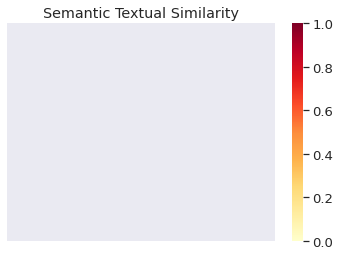

In [27]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 10000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [28]:
comment_index = 324
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

I love her!




Print similar comments.

In [29]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: I love her!


Top similar comment 2: @ i like honey.


Top similar comment 3: I love everything about this channel.


Top similar comment 4: i need meat


Top similar comment 5: I will!


Top similar comment 6: Awesome video!


Top similar comment 7: great vid!


Top similar comment 8: @ I know.


Top similar comment 9: @ I love that last line. :D


Top similar comment 10: so do i too!


Top similar comment 11: Eyyy! Early!


Top similar comment 12: good stuff my man


Top similar comment 13: @ oh ok


Top similar comment 14: Great channel!


Top similar comment 15: great video


Top similar comment 16: Great video!


Top similar comment 17: Hahaha so do I 🙏🙏🙏


Top similar comment 18: @ I will! Thanks :)


Top similar comment 19: Commenting for the algorithm


Top similar comment 20: SAY IT LOUDER


